# Project 4: Predict Dengue Cases

In notebook 3.1, we will test the `time series forecasting models`.<br>
In notebook 3.2, we will test the `regression models`.


**Notebook 3.1 - Time Series Modelling**<br>
* [Time Series Modelling](#Time-Series-Modelling)<br>
* [Predicting up to 12 months ahead](#Predicting-up-to-12-months-ahead)<br>
    * [Premodelling](#Premodelling)<br>
        * [Check Stationarity](#Check-Stationarity)<br>
        * [Determining AR, MA values](#Determining-AR,-MA-values)<br>
        * [Check Seasonality](#Check-Seasonality)<br>
    * [Baseline Model 1 - SARIMA](#Baseline-Model-1---SARIMA)<br>
    * [Model 2 - SARIMAX](#Model-2---SARIMAX)<br>
* [Predicting only 3 months ahead](#Predicting-only-3-months-ahead)<br>
    * [Model 3 - SARIMAX](#Model-3---SARIMAX)<br>
        * [Jan - Mar 2022](#Jan---Mar-2022)<br>
        * [Apr - Jun 2022](#Apr---Jun-2022)<br>
        * [Jul - Sep 2022](#Jul---Sep-2022)<br>
        * [Oct - Dec 2022](#Oct---Dec-2022)<br>
        * [Jan - Mar 2022](#Jan---Mar-2022)<br>
    * [Combined Running 3-month Predictions for 2022](#Combined-Running-3-month-Predictions-for-2022)<br>

**Imports**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  
import pmdarima as pm
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
import compiled_functions

# Time Series Modelling

##### Process
For time-series models, our general process and methodology is as follows. After train-test split:
* Ensure time series data stationarity by using the AD-Fuller Test 
* Plot correlation and autocorrelation charts to determine if we have an autoregressive / moving average model, and what our "p" and "q" values are
* Determine seasonality period ("m" value) through earlier plotted seasonal decomposition chart
* Train our ARIMA and SARIMAX Model
* Make predictions using the respective models

For this notebook, we will test out the following prediction periods:
1. Predicting up to 12 months ahead for the year of 2022, to see if our model is able to pick up the 2022 spike.
2. Predicting up to 3 months ahead, for 4 quarters of 2022. 

## Predicting up to 12 months ahead

**Load pickled dataframe - 12 month (52 weeks) lag**

Load picked dataframes, and check the shape and head:

In [3]:
#load pickled df
dengue_wk = pickle.load(open('../pkls/dengue_lagged_52.pkl', 'rb'))

In [4]:
compiled_functions.shape_head(dengue_wk, "dengue_wk")

dengue_wk dataset shape:
(519, 19)

dengue_wk dataset head:


,df,dhf,dengue_cases,daily_rainf_total,highest_30min_rainf,highest_60min_rainf,highest_120min_rainf,mean_temp,max_temp,min_temp,mean_wind_speed,max_wind_speed,dengue_searches,dengue_fever_searches,dengue_symptoms_searches,daily_rainf_total_squared,highest_30min_rainf_squared,highest_60min_rainf_squared,highest_120min_rainf_squared
2013-01-20,219.000,0.000,219.000,0.600,0.600,0.600,0.600,27.200,31.400,25.200,8.400,28.400,6.000,7.000,3.000,0.360,0.360,0.360,0.360
2013-01-27,264.000,3.000,267.000,4.000,1.468,1.468,1.777,26.971,30.543,24.786,12.214,34.600,6.000,3.000,0.000,16.000,2.156,2.156,3.156
2013-02-03,292.000,1.000,293.000,3.686,0.808,1.158,1.755,26.229,29.500,23.829,7.814,34.214,6.000,3.000,2.000,13.584,0.653,1.342,3.079
2013-02-10,322.000,0.000,322.000,4.000,2.701,3.207,3.225,26.914,31.300,24.471,7.357,28.043,7.000,4.000,1.000,16.000,7.298,10.282,10.402
2013-02-17,246.000,1.000,247.000,1.229,0.872,0.917,0.963,26.600,30.600,24.400,8.586,30.857,8.000,4.000,1.000,1.509,0.760,0.840,0.926


## Premodelling

Since we will be predicting dengue cases through time series modelling, let's call out the dengue_incidence df with only dengue_cases as our y-variable.

In [5]:
dengue_incidence = dengue_wk[['dengue_cases']]
dengue_incidence.head()

,dengue_cases
2013-01-20,219.000
2013-01-27,267.000
2013-02-03,293.000
2013-02-10,322.000
2013-02-17,247.000


### Train Test Split

First, let's set our test set to be year 2022, to see how well our model is able to predict dengue incidence of up to 1 year ahead.

In [6]:
#determine train test ratio
print(f"No of rows of data in total: {dengue_incidence.shape[0]}")
print(f"No of rows of test data: {dengue_incidence.loc['2022'].shape[0]}")
print(f"Percentage of test data / Total rows: {round((dengue_incidence.loc['2022'].shape[0])/(dengue_incidence.shape[0])*100, 2)}%")

No of rows of data in total: 519
No of rows of test data: 52
Percentage of test data / Total rows: 10.02%


In [7]:
y_train = dengue_incidence.iloc[:467]
y_test = dengue_incidence.iloc[467:]

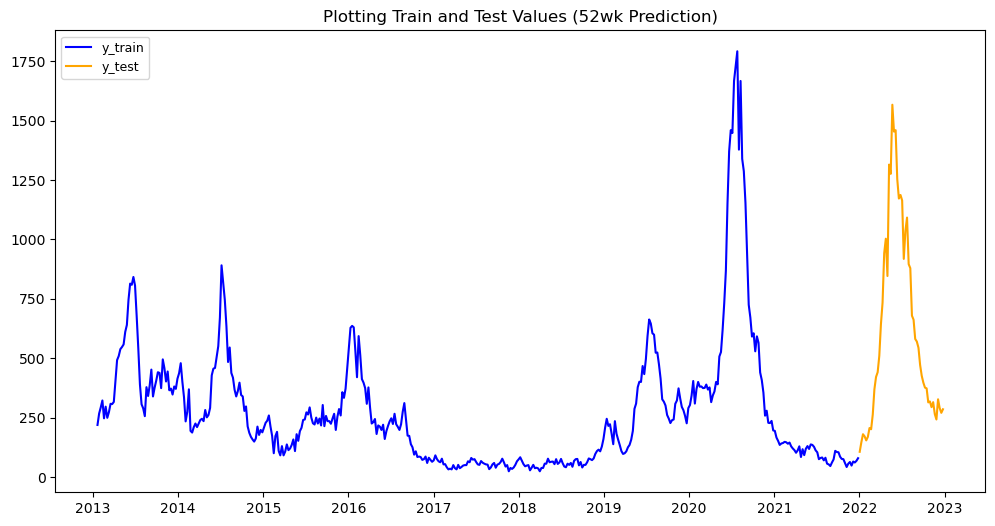

In [8]:
compiled_functions.plot_traintest(y_train, y_test, "Plotting Train and Test Values (52wk Prediction)");

### Check Stationarity

In [9]:
# Check stationarity:
ad_fuller_result = adfuller(y_train['dengue_cases'])
print(f"p-value for original: {str(ad_fuller_result[1])}")

p-value for original: 0.02655686798902468


##### Findings
From the ADF test, p-value is 0.026 (< 0.05). This tells us we can reject the null hypothesis (null hypothesis = the data is not stationary) because it is statistically insignificant. 

### Determining AR, MA values 

ACF and PACF assume stationarity of the underlying time series. <br>
Now that we have confirmed our data is stationary, lets plot a 52-wk ACF, PACF to determine our 'p' and 'q' values:

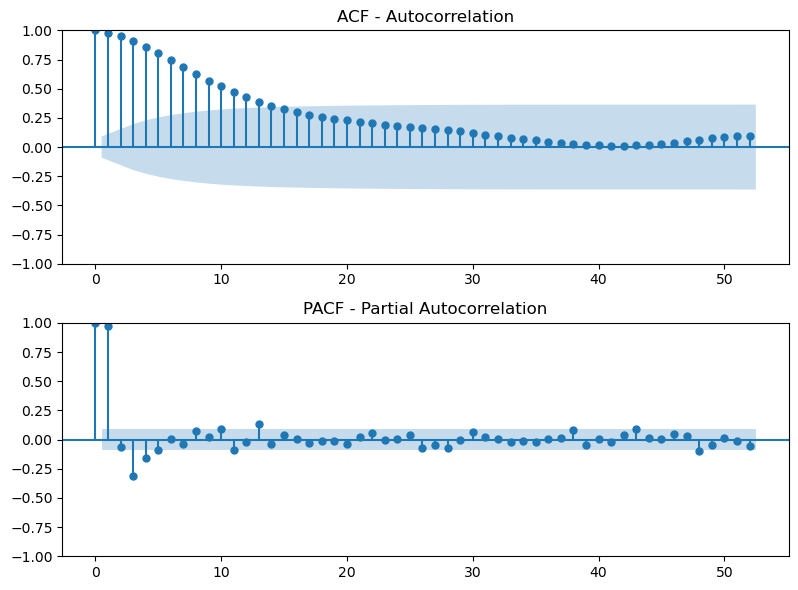

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot ACF for different differencing orders
plot_acf(y_train, lags=52, ax=ax1) 
ax1.set_title("ACF - Autocorrelation", fontsize=12)

plot_pacf(y_train, lags=52, ax=ax2)
ax2.set_title("PACF - Partial Autocorrelation", fontsize=12)

plt.tight_layout()

# Show the plots
plt.show()

##### Findings
* In the ACF plot, we observe geometric decay. The tailing off pattern suggests the suitability of AutoRegression (AR) modeling.
* To determine the order of the autoregression ("p"), we use the Partial Autocorrelation Function (PACF) plot to gain insights. The PACF plot shows a significant drop at lag 2, as it falls within the 95% significance threshold, hence suggesting an AR order of 2 for modeling.

* To determine the orders for moving average ("q"), we look at the Autocorrelation (ACF) plot. The value of "q" could be any of the spikes that go beyond the significance threshold. Hence, let's test a range of values from 1-10.

* We can narrow the range of our auto-arima, by setting the following:
    * `p` - start_p=2, max_p=3
    * `d` - d=0
    * `q` - start_q=1, max_q=10

### Check Seasonality

From the below seasonal_decomposition chart that we plotted earlier in notebook 2, we can already tell that seasonality is present for the dengue data, and period of each cycle is 12 months / 52 weeks (peak-to-peak, trough-to-trough). This determines our 'm' value for SARIMA / SARIMAX, representing seasonality. Hence, `m` = 52.

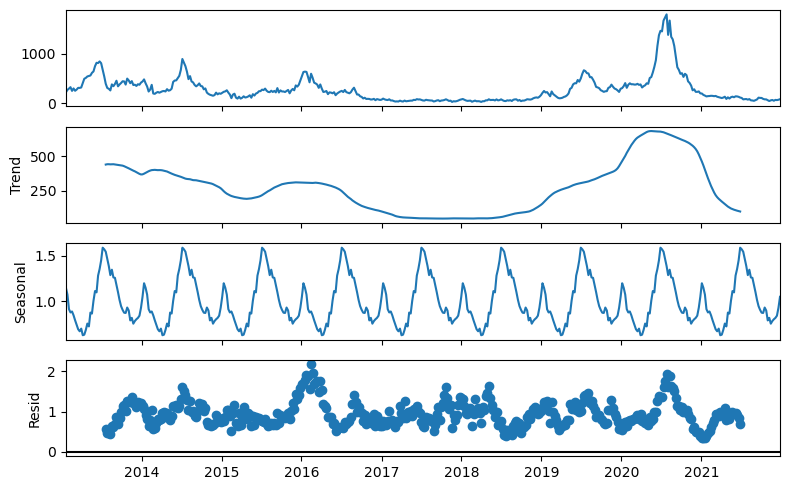

In [11]:
decomposition = seasonal_decompose(y_train, model='multiplicative')

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches((8,5))
fig.tight_layout();

## Baseline Model 1 - SARIMA

In [62]:
#load pickled models
sarima_model = pickle.load(open('../pkls/sarima_model_52wks.pkl', 'rb'))

In [12]:
# Fit Auto SARIMA
sarima_model = pm.AutoARIMA(
                           start_p=2, max_p=3, 
                           d=0,   
                           start_q=1, max_q=10, 
                           
                           start_P=2, max_P=3, 
                           D=0,    
                           start_Q=1, max_Q=10, 
                           m=52, 
                           seasonal=True, 
                           
                           # same parameters as Auto ARIMA
                           trace=True, 
                           random_state=20,
                           n_fits=50
                          )

sarima_model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(2,0,1)[52] intercept   : AIC=5135.953, Time=70.54 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=6551.394, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=5133.954, Time=1.43 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=6064.105, Time=2.34 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=6879.812, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=5132.028, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=5133.958, Time=2.39 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=4.30 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=5131.936, Time=0.10 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=5133.507, Time=3.39 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=5133.542, Time=2.38 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=5134.875, Time=5.29 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=5083.898, Time=0.13 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=5082.229, Time=4.96 sec
 ARIMA(3,0,0)(2,0,0)[52

AutoARIMA(D=0, d=0, m=52, max_P=3, max_Q=10, max_p=3, max_q=10, n_fits=50,
          random_state=20, start_P=2, start_q=1, trace=True)

##### Inferences from Auto SARIMA model
- `AR` best hyperparameter:`p` - 3
- `I` best hyperparameter:`d` - 0 
- `MA` best hyperparameter: `q` - 1

In [13]:
# trained model summary stats
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  467
Model:             SARIMAX(3, 0, 1)x(1, 0, [], 52)   Log Likelihood               -2528.245
Date:                             Wed, 23 Aug 2023   AIC                           5070.489
Time:                                     00:38:46   BIC                           5099.513
Sample:                                 01-20-2013   HQIC                          5081.911
                                      - 12-26-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.2086      2.763      2.609      0.009       1.793      12.624
ar.L1          1.4077      0.066     21.483      0.000       1.279       1.536
ar.L2         -0.1294      0.085     -1.515      0.130      -0.297       0.038
ar.L3         -0.3033      0.029    -10.547      0.000      -0.360      -0.247
ma.L1         -0.4365      0.069     -6.307      0.000      -0.572      -0.301
ar.S.L52      -0.0827      0.048     -1.707      0.088      -0.178       0.012
sigma2      2926.0171     90.436     32.354      0.000    2748.765    3103.269
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2066.41
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.02
Prob(H) (two-sided):                  0.08   Kurtosis:                        13.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

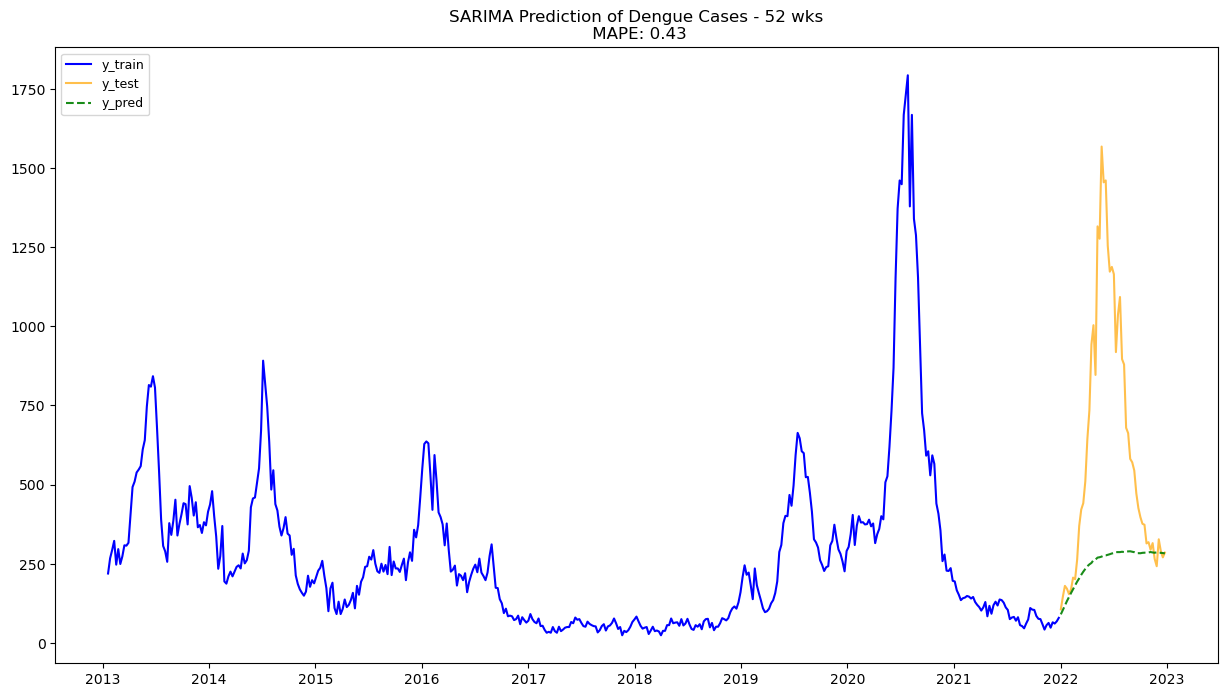

In [14]:
compiled_functions.plot_forecast(y_train, y_test, sarima_model, "SARIMA Prediction of Dengue Cases - 52 wks")

Let's create a function to print our selected evaluation metrics, RMSE and MAPE:

In [15]:
def evaluate_model(model, y_train, y_test):
    # Make predictions on train and test sets
    y_pred_train = model.predict(n_periods = len(y_train))
    y_pred_test = model.predict(n_periods = len(y_test))
    
    # Calculate RMSE and MAPE for train and test sets
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    
    # Print the results
    print("Train RMSE:", rmse_train)
    print("Test RMSE:", rmse_test)
    print("Train MAPE:", mape_train)
    print("Test MAPE:", mape_test)

In [16]:
evaluate_model(sarima_model, y_train, y_test)

Train RMSE: 268.3847974767371
Test RMSE: 533.9823242956494
Train MAPE: 1.4747205943438708
Test MAPE: 0.4341531614542048


##### Findings
From our above model summary stats, and sarima model plot, we can infer the following:
* AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) of our baseline SARIMA can be used as our benchmark score. A low AIC and BIC indicates how well fit a model is (relative to our baseline), and whether there is a balance between goodness of fit and model complexity.
* Visually, on our SARIMA plot, the model seems to be able to slightly pick up the spike in the dengue cases relatively accurately in the first quarter of 2022, before graduating to the mean no of cases.
* From the evaluation metrics looking at errors, test error scores are alot higher than train, indicating a larger error from our testing prediction, which is expected from a full 1 year (52 week) prediction.
* Test MAPE score is 0.43, meaning our forecasts are 57% accurate.

In [17]:
#pickle the model
pickle.dump(sarima_model, open('../pkls/sarima_model_52wks.pkl', 'wb'))

## Model 2 - SARIMAX
As expected, the earlier baseline SARIMA model is rather poor in its prediction. This is because the nature of the SARIMA model is that it only relies on past observations of the target variable itself, and it is unable to account for other exogenous features, such as weather and google trends. These features can variables can provide additional information and context, leading to better forecasting accuracy. Let's add these additional features to form our Seasonal Autoregressive Integrated Moving Average with eXogenous Regressors model (SARIMAX) model.

In [18]:
#recap our earlier dataframe with all features
dengue_wk.head()

,df,dhf,dengue_cases,daily_rainf_total,highest_30min_rainf,highest_60min_rainf,highest_120min_rainf,mean_temp,max_temp,min_temp,mean_wind_speed,max_wind_speed,dengue_searches,dengue_fever_searches,dengue_symptoms_searches,daily_rainf_total_squared,highest_30min_rainf_squared,highest_60min_rainf_squared,highest_120min_rainf_squared
2013-01-20,219.000,0.000,219.000,0.600,0.600,0.600,0.600,27.200,31.400,25.200,8.400,28.400,6.000,7.000,3.000,0.360,0.360,0.360,0.360
2013-01-27,264.000,3.000,267.000,4.000,1.468,1.468,1.777,26.971,30.543,24.786,12.214,34.600,6.000,3.000,0.000,16.000,2.156,2.156,3.156
2013-02-03,292.000,1.000,293.000,3.686,0.808,1.158,1.755,26.229,29.500,23.829,7.814,34.214,6.000,3.000,2.000,13.584,0.653,1.342,3.079
2013-02-10,322.000,0.000,322.000,4.000,2.701,3.207,3.225,26.914,31.300,24.471,7.357,28.043,7.000,4.000,1.000,16.000,7.298,10.282,10.402
2013-02-17,246.000,1.000,247.000,1.229,0.872,0.917,0.963,26.600,30.600,24.400,8.586,30.857,8.000,4.000,1.000,1.509,0.760,0.840,0.926


In [19]:
#drop df and dhf, as we will be using dengue_cases as our y-variable to predict
dengue_wk.drop(columns=['df', 'dhf'], inplace=True)

- Our target variable to forecast: `dengue_cases`
- Let's incorporate our weather and google_trends (exogenous features) `X`.
- Earlier in notebook 2, we have already incorporated the relevant time lags to the various features.

##### Dropping multicollinear features

In [20]:
dengue_wk.columns

Index(['dengue_cases', 'daily_rainf_total', 'highest_30min_rainf',
       'highest_60min_rainf', 'highest_120min_rainf', 'mean_temp', 'max_temp',
       'min_temp', 'mean_wind_speed', 'max_wind_speed', 'dengue_searches',
       'dengue_fever_searches', 'dengue_symptoms_searches',
       'daily_rainf_total_squared', 'highest_30min_rainf_squared',
       'highest_60min_rainf_squared', 'highest_120min_rainf_squared'],
      dtype='object')

Let's drop 'highest_30min_rainf', 'highest_60min_rainf', 'highest_120min_rainf' as these 3 features are multicollinear to the 'daily_rainf_total' (total daily rainfall) feature:

In [21]:
#drop 'highest_30min_rainf', 'highest_60min_rainf', 'highest_120min_rainf'
dengue_wk.drop(columns=['highest_30min_rainf', 'highest_60min_rainf', 'highest_120min_rainf', 'highest_30min_rainf_squared',
       'highest_60min_rainf_squared', 'highest_120min_rainf_squared'], inplace=True)

Let's drop 'min_temp' as it is highly collinear to 'mean_temp':

In [22]:
#drop 'min_temp'
dengue_wk.drop(columns=['min_temp'], inplace=True)

Let's drop 'dengue_fever_searches', 'dengue_symptoms_searches' as these 2 features are multicollinear to the 'dengue_searches' feature:

In [23]:
#drop 'dengue_fever_searches', 'dengue_symptoms_searches'
dengue_wk.drop(columns=['dengue_fever_searches', 'dengue_symptoms_searches'], inplace=True)

### Creating functions for SARIMAX

Let's create a function for train test split:

In [24]:
def sarimax_ttsplit(train_end, test_start, test_end, X, y):
    X_train = X[:train_end]
    X_test = X[test_start:test_end]
    
    y_train = y[:train_end]
    y_test = y[test_start:test_end]

    # Create an instance of MinMaxScaler
    scaler = MinMaxScaler()
    
    # Fit the scaler on your training data and then transform both training and testing data
    Z_train = scaler.fit_transform(X_train)
    Z_test = scaler.transform(X_test)
    
    return Z_train, Z_test, y_train, y_test

Let's create a function to fit our sarimax model:<br>
(Again, we limited the ranges of our p,d,q,P,D,Q to match our earlier findings. d value is fixed to 0 as our original data was already stationary, and m=52 because our data is in weeks and 1 period of seasonality is a year)

In [25]:
def fit_sarimax(y_train, Z_train):
    sarimax_model = pm.AutoARIMA(
        start_p=2, max_p=3, 
        d=0, start_q=1, max_q=10,
        start_P=2, max_P=3,
        D=0, start_Q=1, max_Q=10,
        m=52, seasonal=True,
        trace=True, random_state=20,
        n_fits=50
    )

    sarimax_model.fit(y_train, exogenous=Z_train) 

    return sarimax_model

Let's create a function to print our selected evaluation metrics, RMSE and MAPE:

In [26]:
def evaluate_model(sarimax_model, y_train, y_test):
    # Make predictions on train and test sets
    y_pred_train = sarimax_model.predict(n_periods=(len(y_train)))
    y_pred_test = sarimax_model.predict(n_periods=(len(y_test)))
    
    # Calculate RMSE and MAPE for train and test sets
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    
    # Print the results
    print("Train RMSE:", rmse_train)
    print("Test RMSE:", rmse_test)
    print("Train MAPE:", mape_train)
    print("Test MAPE:", mape_test)

### Train Test Split

In [28]:
X = dengue_wk.drop(columns=['dengue_cases'])
y = dengue_wk['dengue_cases']


Z_train, Z_test, y_train, y_test = sarimax_ttsplit('2021', '2022-01', '2022-12', X, y)

### Fit SARIMAX

In [42]:
#load pickled models
sarimax_model = pickle.load(open('../pkls/sarimax_model_52wks.pkl', 'rb'))

In [29]:
sarimax_model = fit_sarimax(y_train, Z_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(2,0,1)[52] intercept   : AIC=5135.953, Time=71.54 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=6551.394, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=5133.954, Time=1.42 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=6064.105, Time=2.32 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=6879.812, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=5132.028, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=5133.958, Time=2.43 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=4.42 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=5131.936, Time=0.10 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=5133.507, Time=3.35 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=5133.542, Time=2.46 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=5134.875, Time=5.40 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=5083.898, Time=0.15 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=5082.229, Time=5.02 sec
 ARIMA(3,0,0)(2,0,0)[52

### SARIMAX Model summary

In [30]:
# trained model summary stats
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  467
Model:             SARIMAX(3, 0, 1)x(1, 0, [], 52)   Log Likelihood               -2528.245
Date:                             Wed, 23 Aug 2023   AIC                           5070.489
Time:                                     01:18:30   BIC                           5099.513
Sample:                                 01-20-2013   HQIC                          5081.911
                                      - 12-26-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.2086      2.763      2.609      0.009       1.793      12.624
ar.L1          1.4077      0.066     21.483      0.000       1.279       1.536
ar.L2         -0.1294      0.085     -1.515      0.130      -0.297       0.038
ar.L3         -0.3033      0.029    -10.547      0.000      -0.360      -0.247
ma.L1         -0.4365      0.069     -6.307      0.000      -0.572      -0.301
ar.S.L52      -0.0827      0.048     -1.707      0.088      -0.178       0.012
sigma2      2926.0171     90.436     32.354      0.000    2748.765    3103.269
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2066.41
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.02
Prob(H) (two-sided):                  0.08   Kurtosis:                        13.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Plot Prediction

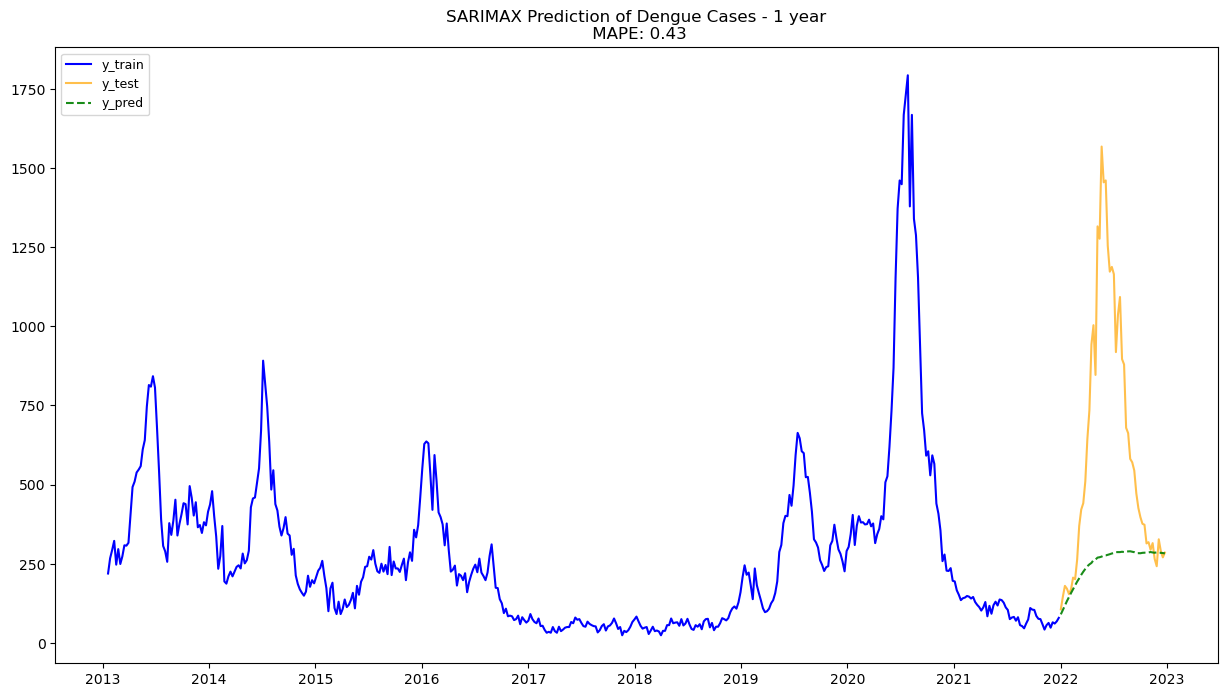

In [31]:
compiled_functions.plot_forecast(y_train, y_test, sarimax_model, "SARIMAX Prediction of Dengue Cases - 1 year", X_test=Z_test)

### Evaluate

In [32]:
evaluate_model(sarimax_model, y_train, y_test)

Train RMSE: 268.3847974767371
Test RMSE: 533.9823242956494
Train MAPE: 1.4747205943438708
Test MAPE: 0.4341531614542048


### Findings

From our above model summary stats, and sarimax model plot, we can infer the following:
* AIC for SARIMAX is similar to our baseline SARIMA model's AIC of 5070, meaning it did not manage to perform better despite taking into consideration exogeneous variables.
* Visually, similar to the SARIMAX plot, the model seems to be able to slightly pick up the spike in the dengue cases relatively accurately in the first quarter of 2022, before graduating to the mean no of cases.
* From the evaluation metrics looking at errors, the RMSE scores for train and test are quite similar, indicating a well fit model.
* Test MAPE score is 0.43, meaning our forecasts are 57% accurate for the full 1 year prediction.

In [33]:
#pickle the model
pickle.dump(sarimax_model, open('../pkls/sarimax_model_52wks.pkl', 'wb'))

## Predicting only 3 months ahead

As our earlier SARIMA and SARIMAX models are unable to accurately predict 1 full year (52weeks) ahead, we will now refine our production model to predict just 3 months ahead, as our earlier research tells us that [3 months is an ideal amount of lead time for a forecast](https://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0001848#:~:text=Our%20findings%20show%20that%20increasing,on%20the%20observed%20weather%20data). Insights from our EDA also allow us to expect that the 3-mth prediction would be more accurate than the 12-mth prediction window.  <br>

let's explore running 3 month predictions for the year of 2022:
* Jan - Mar
* Apr - Jun
* Jul - Aug
* Sep - Dec

**Load pickled dataframe - 3 month (12 weeks) lag**

Load picked dataframes, drop columns that were dropped earlier (similar to 52wks df) and check the shape and head:

In [34]:
#load pickled df
dengue_12wk = pickle.load(open('../pkls/dengue_lagged_12.pkl', 'rb'))

#drop columns with multicollinearity
dengue_12wk.drop(columns=['df', 'dhf', 'highest_30min_rainf', 'highest_60min_rainf', 'highest_120min_rainf', 'min_temp',
                         'dengue_fever_searches', 'dengue_symptoms_searches', 'highest_30min_rainf_squared',
                          'highest_60min_rainf_squared', 'highest_120min_rainf_squared'], inplace=True)

In [35]:
compiled_functions.shape_head(dengue_12wk, "dengue_12wk")

dengue_12wk dataset shape:
(559, 8)

dengue_12wk dataset head:


,dengue_cases,daily_rainf_total,mean_temp,max_temp,mean_wind_speed,max_wind_speed,dengue_searches,daily_rainf_total_squared
2012-04-15,77.000,0.600,27.200,31.400,8.400,28.400,6.000,0.360
2012-04-22,64.000,4.000,26.971,30.543,12.214,34.600,6.000,16.000
2012-04-29,88.000,3.686,26.229,29.500,7.814,34.214,6.000,13.584
2012-05-06,97.000,4.000,26.914,31.300,7.357,28.043,7.000,16.000
2012-05-13,80.000,1.229,26.600,30.600,8.586,30.857,8.000,1.509


In [36]:
#define X and y vars
X = dengue_12wk.drop(columns=['dengue_cases'])
y = dengue_12wk['dengue_cases']

## Model 3 - SARIMAX


### Jan - Mar 2022

In [42]:
#load picked models
sarimax_model_jan_mar = pickle.load(open('../pkls/sarimax_model_jan_mar.pkl', 'rb'))

In [37]:
#train test split for mentioned duration
X_train_jan_mar, X_test_jan_mar, y_train_jan_mar, y_test_jan_mar = sarimax_ttsplit('2021-12', '2022-01', '2022-03', X, y)

In [38]:
sarimax_model_jan_mar = fit_sarimax(y_train_jan_mar, X_train_jan_mar)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(2,0,1)[52] intercept   : AIC=inf, Time=81.56 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7086.510, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=5536.711, Time=1.44 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=6558.195, Time=2.24 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7430.628, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=5534.715, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=5536.703, Time=2.57 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=4.14 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=5534.473, Time=0.10 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=5536.251, Time=1.98 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=5536.272, Time=1.79 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=5537.711, Time=6.39 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=5482.694, Time=0.22 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=5481.794, Time=6.42 sec
 ARIMA(3,0,0)(2,0,0)[52] int

In [39]:
evaluate_model(sarimax_model_jan_mar, y_train_jan_mar, y_test_jan_mar)

Train RMSE: 260.3270625811531
Test RMSE: 133.94443842227355
Train MAPE: 1.381001898713612
Test MAPE: 0.3089163200870966


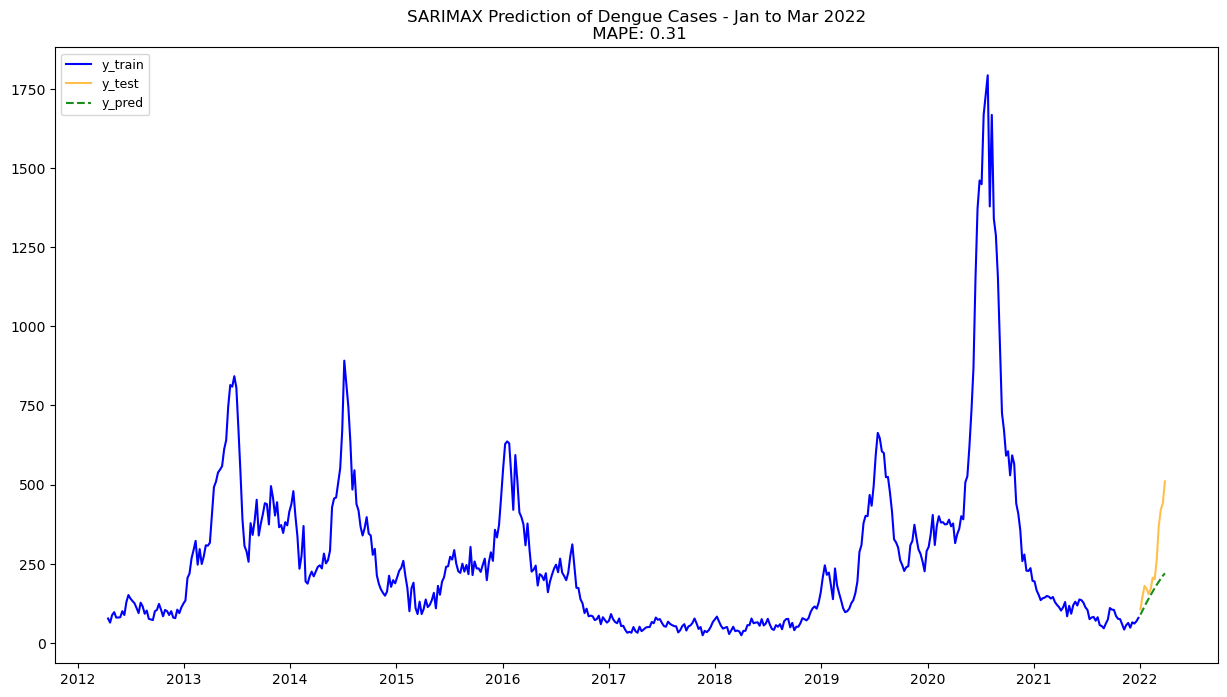

In [40]:
compiled_functions.plot_forecast(y_train_jan_mar, y_test_jan_mar, sarimax_model_jan_mar, "SARIMAX Prediction of Dengue Cases - Jan to Mar 2022", X_test=X_test_jan_mar)

##### Findings from 1st Quarter Prediction
* Compared to the 52week prediction, while train RMSE remained the same, the test RMSE dropped significantly, indicating the ability of the model to better pick up on the early upward trend of the spike in the first quarter of 2022.
* Train RMSE performs worse than test RMSE. This outcome can be attributed to the model's exposure to a longer historical period of around nine years, which encompasses many outliers. 
* Test RMSE is 133.
* Test MAPE score is 0.31, meaning our forecasts are 69% accurate for the quarterly prediction from Jan-Mar 2022.

In [41]:
#pickle the model
pickle.dump(sarimax_model_jan_mar, open('../pkls/sarimax_model_jan_mar.pkl', 'wb'))

### Apr - Jun 2022

In [63]:
#load picked models
sarimax_model_apr_jun = pickle.load(open('../pkls/sarimax_model_apr_jun.pkl', 'rb'))

In [43]:
#train test split for mentioned duration
X_train_apr_jun, X_test_apr_jun, y_train_apr_jun, y_test_apr_jun = sarimax_ttsplit('2022.03', '2022.04', '2022.06', X, y)

In [44]:
sarimax_model_apr_jun = fit_sarimax(y_train_apr_jun, X_train_apr_jun)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(2,0,1)[52] intercept   : AIC=5676.098, Time=86.12 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7258.091, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=5674.457, Time=1.53 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=6716.278, Time=2.28 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7615.971, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=5672.471, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=5674.462, Time=1.47 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=4.04 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=5671.467, Time=0.21 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=5673.134, Time=2.01 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=5673.151, Time=3.61 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=5674.502, Time=5.53 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=5617.931, Time=0.19 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=5616.781, Time=5.12 sec
 ARIMA(3,0,0)(2,0,0)[52

In [45]:
evaluate_model(sarimax_model_apr_jun, y_train_apr_jun, y_test_apr_jun)

Train RMSE: 268.1675794905824
Test RMSE: 700.5363699818658
Train MAPE: 1.5382211147798992
Test MAPE: 0.5185719476037668


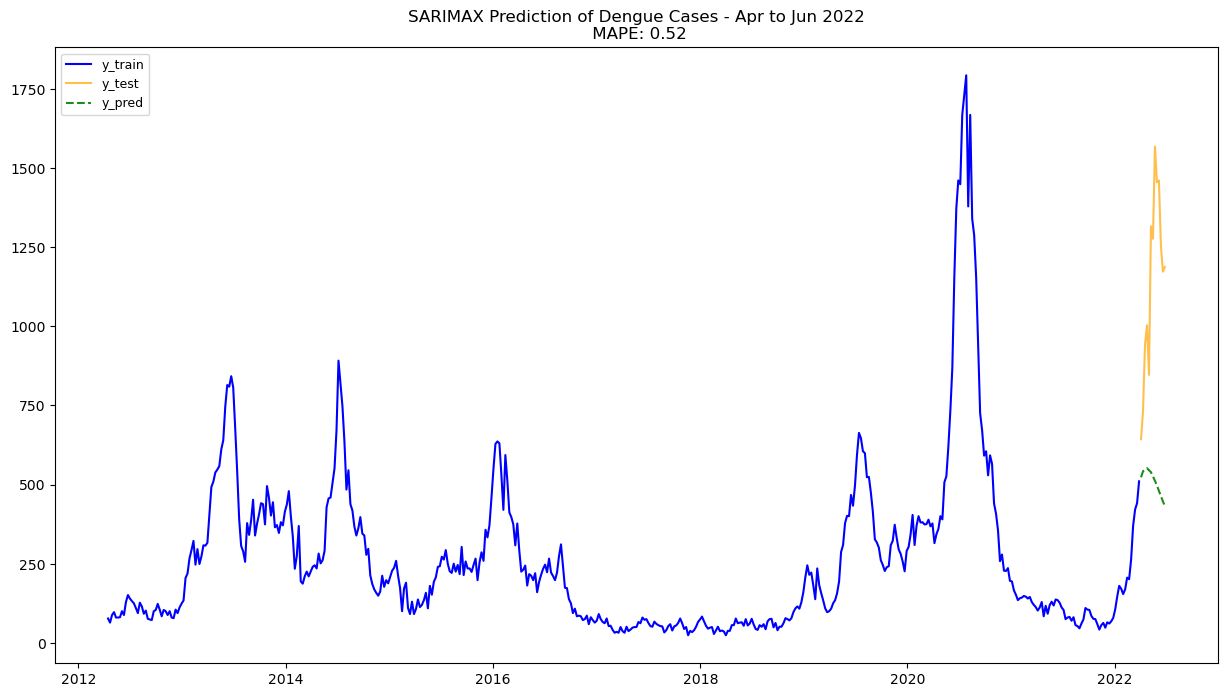

In [46]:
compiled_functions.plot_forecast(y_train_apr_jun, y_test_apr_jun, sarimax_model_apr_jun, "SARIMAX Prediction of Dengue Cases - Apr to Jun 2022", X_test=X_test_apr_jun)

##### Findings from 2nd Quarter Prediction
* We can see that our model managed to predict a slight peak, indicating some degree of responsiveness. However, it's important to note that the magnitude of the peak predicted by our model did not align closely with the actual spike observed in the data during the second quarter of 2022. 
* As a result, Test RMSE is high for this 2nd Quarter, with a score of 696.
* Test MAPE score is 0.51, meaning our forecasts are 49% accurate for the quarterly prediction from Apr-Jul 2022.
* Our model may not be effective in predicting the surge, because we are unable to capture inherent complexities within the data. We will need alot of data for factors that could contribute to this surge, such as serotype information that most likely influenced the dynamics of the dengue surge.

In [47]:
#pickle the model
pickle.dump(sarimax_model_apr_jun, open('../pkls/sarimax_model_apr_jun.pkl', 'wb'))

### Jul - Sep 2022

In [64]:
#load picked models
sarimax_model_jul_sep = pickle.load(open('../pkls/sarimax_model_jul_sep.pkl', 'rb'))

In [48]:
#train test split for mentioned duration
X_train_jul_sep, X_test_jul_sep, y_train_jul_sep, y_test_jul_sep = sarimax_ttsplit('2022.06', '2022.07', '2022.09', X, y)

In [49]:
sarimax_model_jul_sep = fit_sarimax(y_train_jul_sep, X_train_jul_sep)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(2,0,1)[52] intercept   : AIC=inf, Time=91.17 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7571.571, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=5938.867, Time=1.91 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=7021.973, Time=2.56 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7915.613, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=5936.976, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=5938.876, Time=2.42 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=5940.607, Time=3.20 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=5938.700, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=5938.824, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=7020.019, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept   : AIC=5930.619, Time=0.19 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=5932.600, Time=4.06 sec
 ARIMA(2,0,1)(0,0,1)[52] intercept   : AIC=5932.600, Time=4.19 sec
 ARIMA(2,0,1)(1,0,1)[52

In [50]:
evaluate_model(sarimax_model_jul_sep,y_train_jul_sep, y_test_jul_sep)

Train RMSE: 311.7489734610322
Test RMSE: 76.5347465330963
Train MAPE: 1.7141256859870029
Test MAPE: 0.06694071690470435


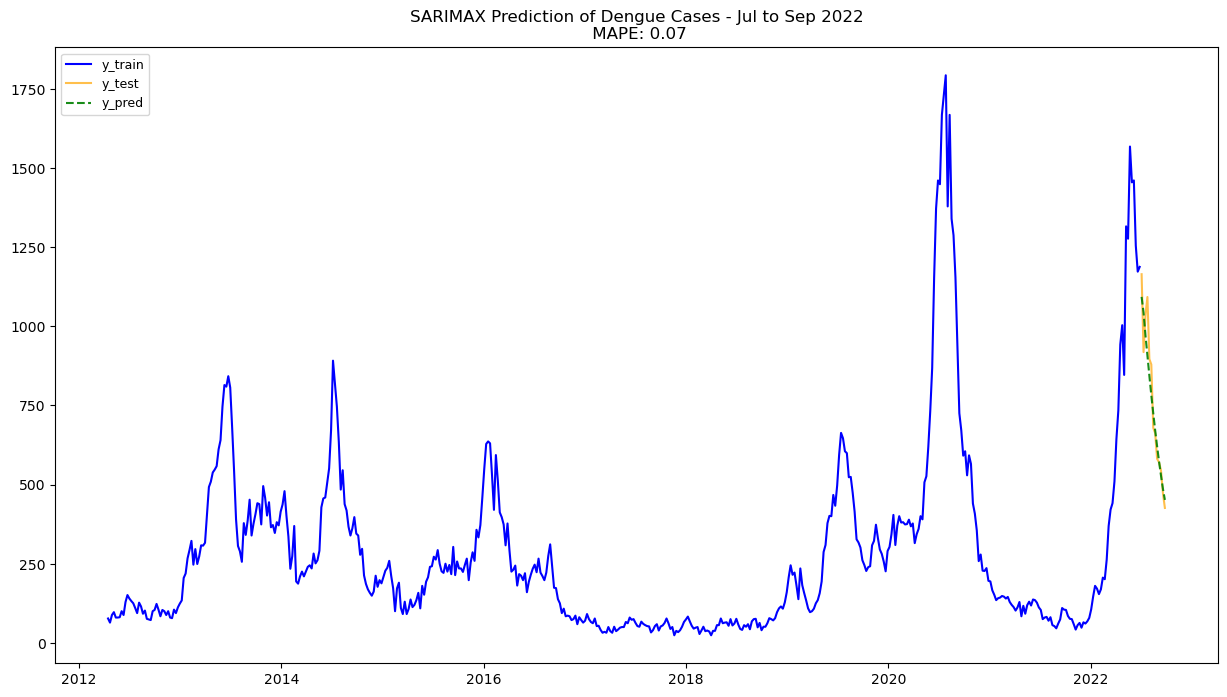

In [51]:
compiled_functions.plot_forecast(y_train_jul_sep, y_test_jul_sep, sarimax_model_jul_sep, "SARIMAX Prediction of Dengue Cases - Jul to Sep 2022", X_test=X_test_jul_sep)

##### Findings from 3rd Quarter Prediction
* Our model demonstrates the ability to capture downward trends in the dengue cases, suggesting that the model might be more sensitive to shifts towards lower values in the target variable.
* As a result, Test RMSE is decent for this 3rd Quarter, with a score of 76.
* Test MAPE score is 0.07, meaning our forecasts are 93% accurate for the quarterly prediction from Jul-Sep 2022.

In [52]:
#pickle the model
pickle.dump(sarimax_model_jul_sep, open('../pkls/sarimax_model_jul_sep.pkl', 'wb'))

### Oct - Dec 2022

In [65]:
#load picked models
sarimax_model_oct_dec = pickle.load(open('../pkls/sarimax_model_oct_dec.pkl', 'rb'))

In [53]:
#train test split for mentioned duration
X_train_oct_dec, X_test_oct_dec, y_train_oct_dec, y_test_oct_dec = sarimax_ttsplit('2022.09', '2022.10', '2022.12', X, y)

In [54]:
sarimax_model_oct_dec = fit_sarimax(y_train_oct_dec, X_train_oct_dec)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(2,0,1)[52] intercept   : AIC=6101.735, Time=100.94 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=7785.361, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=6108.969, Time=1.82 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=7220.664, Time=2.48 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=8144.918, Time=0.02 sec
 ARIMA(2,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=9.20 sec
 ARIMA(2,0,1)(2,0,0)[52] intercept   : AIC=6100.998, Time=48.16 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=6103.755, Time=6.26 sec
 ARIMA(2,0,1)(3,0,0)[52] intercept   : AIC=6102.540, Time=100.51 sec
 ARIMA(2,0,1)(3,0,1)[52] intercept   : AIC=6103.772, Time=194.60 sec
 ARIMA(1,0,1)(2,0,0)[52] intercept   : AIC=6107.603, Time=33.32 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=6107.390, Time=50.30 sec
 ARIMA(3,0,1)(2,0,0)[52] intercept   : AIC=6029.066, Time=85.71 sec
 ARIMA(3,0,1)(1,0,0)[52] intercept   : AIC=6028.741, Time=8.32 sec
 ARIMA(3,0,1)(

In [55]:
evaluate_model(sarimax_model_oct_dec, y_train_oct_dec, y_test_oct_dec)

Train RMSE: 300.1631637812884
Test RMSE: 49.332067719496806
Train MAPE: 1.5369907286674944
Test MAPE: 0.1351226632907048


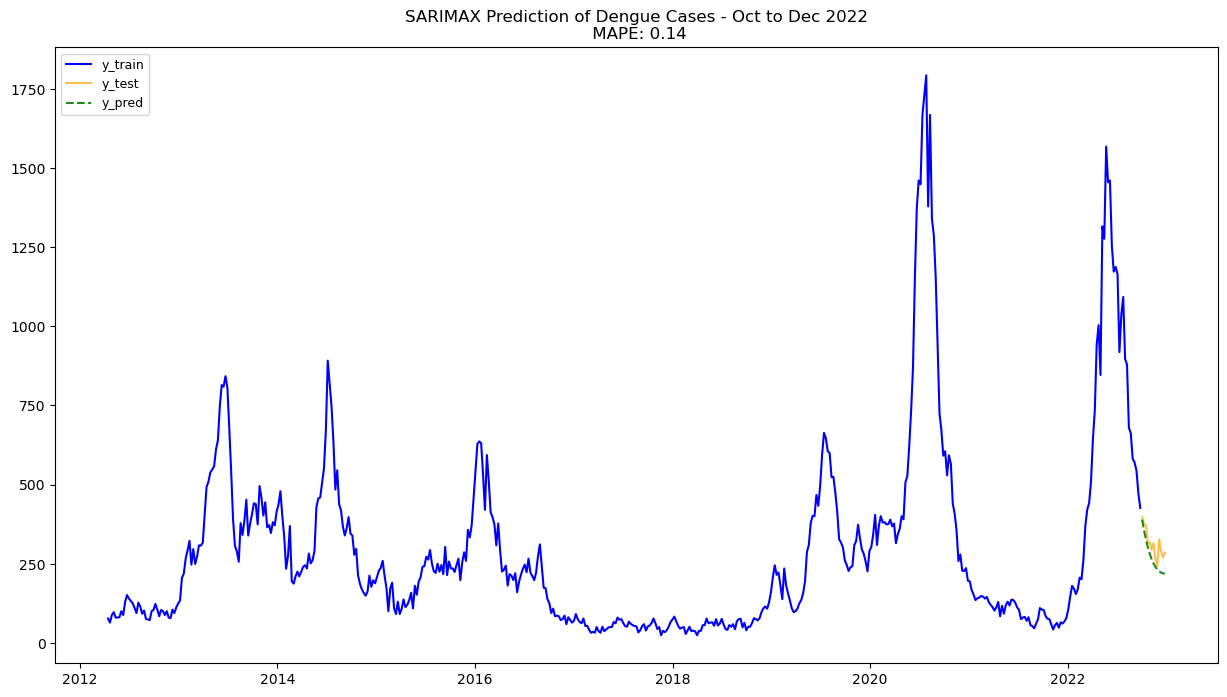

In [56]:
compiled_functions.plot_forecast(y_train_oct_dec, y_test_oct_dec, sarimax_model_oct_dec, "SARIMAX Prediction of Dengue Cases - Oct to Dec 2022", X_test=X_test_oct_dec)

##### Findings from 4th Quarter Prediction
* Again, our model is able to predict the final quarter of downward trend, however the model might not be capturing the precise nuances of the observed undulations within the downward trend.
* Test RMSE is decent for this 4th Quarter, with a score of 49.
* Test MAPE score is 0.12, meaning our forecasts are 86% accurate for the quarterly prediction from Oct to Dec 2022.

In [57]:
#pickle the model
pickle.dump(sarimax_model_oct_dec, open('../pkls/sarimax_model_oct_dec.pkl', 'wb'))

### Combined Running 3-month Predictions for 2022

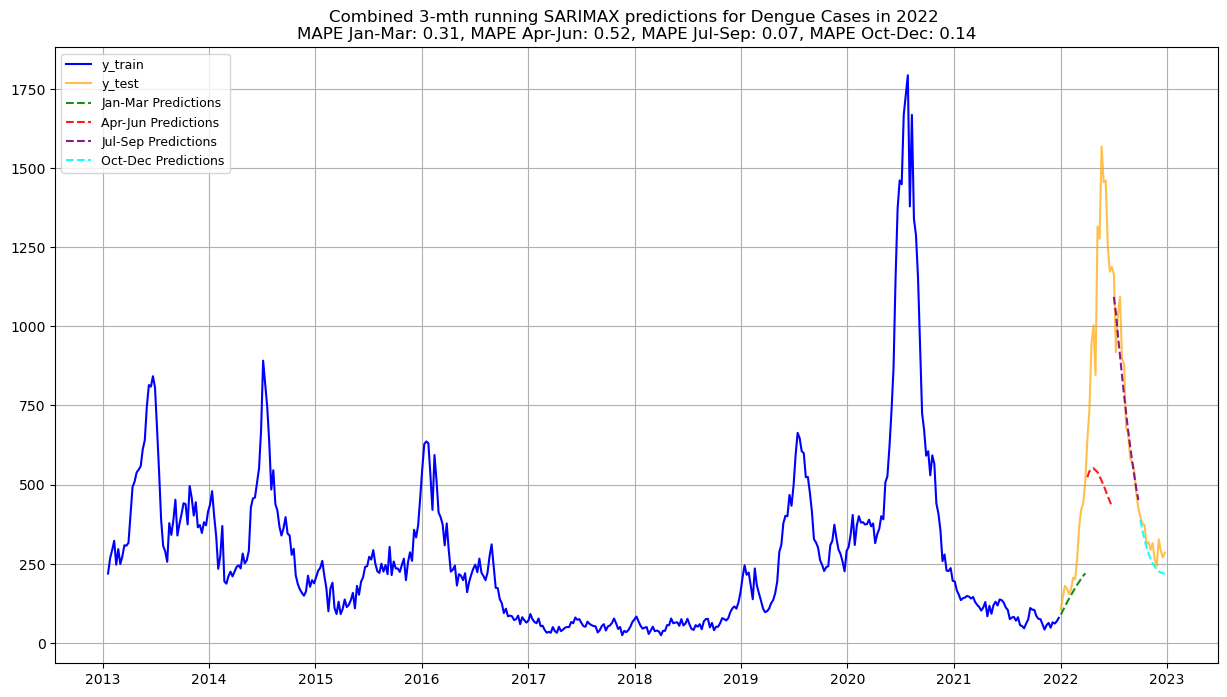

In [60]:
# Generate len(y_test) number of predictions
y_pred_jan_mar = sarimax_model_jan_mar.predict(n_periods = len(y_test_jan_mar), X=X_test_jan_mar)
y_pred_apr_jun = sarimax_model_apr_jun.predict(n_periods = len(y_test_apr_jun), X=X_test_apr_jun)
y_pred_jul_sep = sarimax_model_jul_sep.predict(n_periods = len(y_test_jul_sep), X=X_test_jul_sep)
y_pred_oct_dec = sarimax_model_oct_dec.predict(n_periods = len(y_test_oct_dec), X=X_test_oct_dec)

plt.figure(figsize=(15, 8))
plt.plot(y_train, color='blue', label='y_train') 
plt.plot(y_test, color='orange', label='y_test', alpha=0.7)  

# Plot predicted test values for each time period
plt.plot(y_pred_jan_mar, color='green', label='Jan-Mar Predictions', alpha=0.9, ls='--')
plt.plot(y_pred_apr_jun, color='red', label='Apr-Jun Predictions', alpha=0.9, ls='--')
plt.plot(y_pred_jul_sep, color='purple', label='Jul-Sep Predictions', alpha=0.9, ls='--')
plt.plot(y_pred_oct_dec, color='cyan', label='Oct-Dec Predictions', alpha=0.9, ls='--')

# Calculate MAPE for each time period
mape_jan_mar = mean_absolute_percentage_error(y_test_jan_mar, y_pred_jan_mar)
mape_apr_jun = mean_absolute_percentage_error(y_test_apr_jun, y_pred_apr_jun)
mape_jul_sep = mean_absolute_percentage_error(y_test_jul_sep, y_pred_jul_sep)
mape_oct_dec = mean_absolute_percentage_error(y_test_oct_dec, y_pred_oct_dec)

plt.title(label=f'Combined 3-mth running SARIMAX predictions for Dengue Cases in 2022 \n'
               f'MAPE Jan-Mar: {mape_jan_mar:.2f}, '
               f'MAPE Apr-Jun: {mape_apr_jun:.2f}, '
               f'MAPE Jul-Sep: {mape_jul_sep:.2f}, '
               f'MAPE Oct-Dec: {mape_oct_dec:.2f}', fontsize=12)
plt.legend(fontsize=9, loc='upper left')
plt.grid() 
plt.show()

#### Findings
Summarising the performance of our SARIMAX model across three month prediction windows for year 2022 as a whole, here are some key observations: <br>

* **Enhanced Short-Term Accuracy:** <br> Our SARIMAX model consistently demonstrates stronger predictive capability when operating within shorter three-month intervals. The model's accuracy improves when focused on immediate changes and fluctuations within the data, resulting in more accurate predictions for these compact timeframes.

* **Differential Performance in Trends:** <br> The model excels in accurately predicting downward trends in dengue cases. However, it exhibits challenges in effectively capturing upward spikes or surges in cases. This suggests that the model may require more complex data inputs to capture factors that contribute to surges, such as serotype information that can significantly impact the dynamics of dengue outbreaks.

These observations underscore the model's strengths in responding to short-term changes and trends while highlighting areas for improvement, especially in addressing unexpected spikes.